In [3]:
import wbdata
import pandas as pd
import numpy as np
import json
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import warnings
import math
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from ast import literal_eval  #Is used to safely evaluate a string that looks like a Python literal 
import logging
# Suppress OpenAI cache logs
logging.getLogger("openai._base_client").setLevel(logging.ERROR)
logging.getLogger("shelved_cache").setLevel(logging.ERROR)
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
logging.getLogger('shelved_cache.persistent_cache').setLevel(logging.ERROR) #Libraries warnings
warnings.filterwarnings('ignore') #Python warnings


Key '1744978902848454444' not in persistent cache.
Key '-8557872779805584901' not in persistent cache.
Key '-4654813256748254401' not in persistent cache.
Key '-8755150842629776778' not in persistent cache.
Key '-4852091319572446278' not in persistent cache.
Key '756499577676561867' not in persistent cache.
Key '-1262552405560039264' not in persistent cache.
Key '-5444748599222757086' not in persistent cache.
Key '-1541689076165426586' not in persistent cache.
Key '1723143025833131720' not in persistent cache.
Key '6831854052825126269' not in persistent cache.
Key '-665801209192238022' not in persistent cache.
Key '-48641012844168413' not in persistent cache.
Key '-609898208528012543' not in persistent cache.
Key '-8107553470545376834' not in persistent cache.
Key '-7490393274197307225' not in persistent cache.
Key '-1976136735637632185' not in persistent cache.
Key '1926922787419698315' not in persistent cache.
Key '5191754889418256621' not in persistent cache.
Key '-35781790601526335

In [4]:
import tiktoken

# Use OpenAI tokenizer to calculate token lengths (optional, more accurate)
def estimate_token_count(text, model="gpt-3.5-turbo-instruct"):
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

### Prompt to retrieve the best indicators for our analysis

In [5]:
wbdata.get_sources()

  id  name
----  --------------------------------------------------------------------
   1  Doing Business
   2  World Development Indicators
   3  Worldwide Governance Indicators
   5  Subnational Malnutrition Database
   6  International Debt Statistics
  11  Africa Development Indicators
  12  Education Statistics
  13  Enterprise Surveys
  14  Gender Statistics
  15  Global Economic Monitor
  16  Health Nutrition and Population Statistics
  18  IDA Results Measurement System
  19  Millennium Development Goals
  20  Quarterly Public Sector Debt
  22  Quarterly External Debt Statistics SDDS
  23  Quarterly External Debt Statistics GDDS
  25  Jobs
  27  Global Economic Prospects
  28  Global Financial Inclusion
  29  The Atlas of Social Protection: Indicators of Resilience and Equity
  30  Exporter Dynamics Database – Indicators at Country-Year Level
  31  Country Policy and Institutional Assessment
  32  Global Financial Development
  33  G20 Financial Inclusion Indicators
  34  Glob

In [6]:
base_prompt = """
You are a data scientist responsible for selecting the most relevant development indicators to help predict when a country will reach the GDP per capita level typical of developed nations.

Below is a list of available indicators retrieved from the World Bank. Each item contains an indicator code and its corresponding name. You must select exactly {number_of_indicators_per_chunk} indicators from this list:

{chunked_indicators}

Your task:
- Choose indicators that are strongly associated with GDP growth, economic development, or structural transformation (e.g., education, infrastructure, industrialization, trade, institutions).
- Give preference to leading indicators or those with potential causal impact on development and health.
- Ensure diversity across key domains: macroeconomy, infrastructure, education, health, technology, labor, and governance.
- Select exactly {number_of_indicators_per_chunk} indicators — do not exceed this number.
- Do not select any indicator related to CPIA.
- The resulting dictionary must contain exactly {number_of_indicators_per_chunk} key-value pairs.

Output format:
- Return a valid Python dictionary where each key is an indicator code and each value is a concise, cleaned summary of the indicator's meaning.
- Clean indicator names by removing special characters, keeping only letters, spaces, and the '%' symbol.
- Do not include code fences, markdown formatting, comments, or line breaks.
- Output only the dictionary in a single line, formatted like:

dict_indicators = {{'CODE1': 'Abstract indicator meaning 1', 'CODE2': 'Abstract indicator meaning 2'}}
"""

Since we are going to use an LLM to retrieve the most relevant indicators and the list of available indicators is quite large, we need to create chunks to use with our LLM model without encountering any prompt size issues.

In [7]:
available_indicators = wbdata.get_indicators(source=2) #   Source 2 = World Development Indicators

df_indicators = pd.DataFrame(available_indicators)[['id','name']]

enc = tiktoken.encoding_for_model("gpt-3.5-turbo-instruct")
df_indicators["token_count"] = df_indicators["name"].apply(lambda x: len(enc.encode(x)))

base_prompt_count = estimate_token_count(base_prompt)
model_max_tokens = 2500   # Model's maximum context length is 4097 tokens
max_prompt_tokens = model_max_tokens - base_prompt_count
chunk_index = []

for i in range(1,len(df_indicators)):
    if len(chunk_index) == 0:
        list_indicators = "\n".join((df_indicators["id"][0:i] + ": " + df_indicators["name"][0:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    else:
        list_indicators = "\n".join((df_indicators["id"][current_index:i] + ": " + df_indicators["name"][current_index:i]).tolist())
        token_count = estimate_token_count(list_indicators)
    if token_count>max_prompt_tokens:
        current_index = i
        chunk_index.append(i)
        token_count = 0

list_indicators = (df_indicators["id"] + ": " + df_indicators["name"]).tolist()

chunks = [
    list_indicators[0:index] if i == 0 
    else list_indicators[chunk_index[i-1]:index]
    for i, index in enumerate(chunk_index)
]


In [8]:
# Load credentials
with open("credentials.json", "r") as file:
    credentials = json.load(file)

# Initialize the client
client = OpenAI(
    api_key=credentials["OPENAI_API_KEY"],
    base_url=credentials["OPENAI_API_BASE"]  # Only if using a proxy/alternative endpoint
)

# Decoding parameters
TEMPERATURE = 0.0
def query_openai(prompt):

    response = client.completions.create(
        model="gpt-3.5-turbo-instruct",
        prompt=prompt,
        temperature=TEMPERATURE,
        max_tokens=300  

    )
    time.sleep(5)  # rate limiting
    
    return response


In [83]:
max_indicators = 150
n_chunks =  len(chunks)
number_of_indicators_per_chunk = math.ceil(max_indicators/n_chunks)

merged_dict = {}
responses = []
for idx, chunk in enumerate(chunks):
    print(f"\n Running chunk {idx+1}/{n_chunks}...")
    chunk_text = "\n".join(chunk)

    prompt = base_prompt.format(
        chunked_indicators=chunk_text,
        number_of_indicators_per_chunk=number_of_indicators_per_chunk
    )
    
    success = False
    retries = 3
    for attempt in range(1, retries + 1):
        try:
            print(f"Attempt {attempt}...", end=" ")
            response = query_openai(prompt)
            responses.append(response)
            # extract dict with regex
            raw_text = response.choices[0].text.replace('\r', '').replace('\n', '').replace('\t', '').strip()+"'"+'}'
            match = re.search(r"\{.*?\}", raw_text, re.DOTALL)
            if not match:
                raise ValueError("No dictionary found in model response.")
            
            chunk_dict = literal_eval(match.group(0))
            merged_dict.update(chunk_dict)
            print("Success.")
            success = True
            break
        except Exception as e:

            print(f"Error: {e}")
            if attempt < retries:
                time.sleep(5)  # wait before retry
            else:
                print(f"Failed chunk {idx+1} after {retries} attempts.")




 Running chunk 1/15...
Attempt 1... Success.

 Running chunk 2/15...
Attempt 1... Success.

 Running chunk 3/15...
Attempt 1... Success.

 Running chunk 4/15...
Attempt 1... Success.

 Running chunk 5/15...
Attempt 1... Success.

 Running chunk 6/15...
Attempt 1... Success.

 Running chunk 7/15...
Attempt 1... Success.

 Running chunk 8/15...
Attempt 1... Success.

 Running chunk 9/15...
Attempt 1... Success.

 Running chunk 10/15...
Attempt 1... Success.

 Running chunk 11/15...
Attempt 1... Success.

 Running chunk 12/15...
Attempt 1... Success.

 Running chunk 13/15...
Attempt 1... Success.

 Running chunk 14/15...
Attempt 1... Success.

 Running chunk 15/15...
Attempt 1... Success.


Selecting just America countries

In [ ]:
america_countries = [
    'ARG', 'BLZ', 'BOL', 'BRA', 'CAN', 'CHL', 'COL', 
    'CRI', 'ECU', 'SLV', 'GTM', 'GUY', 'HND', 'MEX', 
    'NIC', 'PAN', 'PRY', 'PER', 'SUR', 'USA', 'URY'
]

# Adding target variable
merged_dict.update({'NY.GDP.PCAP.CD':'GDP per capita (current US$)'})

df = wbdata.get_dataframe(merged_dict, country=america_countries,date=("2000", "2023"))
df.reset_index(inplace = True)
# df.dropna(inplace=True)
df.to_csv('df_indicators.csv',index=False)

In [88]:
df  = pd.read_csv('df_indicators.csv',index_col=0)

In [90]:
def mull_heat_map(df, column_to_group):    
    # Calculate null rate by group (e.g., country or date)
    null_rates = df.groupby(column_to_group).apply(lambda x: x.isnull().mean())
    null_rates = null_rates.T  # Transpose for better visualization

    # Create heatmap
    plt.figure(figsize=(30 ,30))
    sns.heatmap(
        null_rates,
        cmap='YlOrRd',
        annot=True,
        fmt='.1%',
        linewidths=.5,
        cbar_kws={'label': 'Null Rate'}
    )

    # Titles and axis labels with bigger fonts
    plt.title('Null Rate by '+column_to_group, fontsize=12)
    plt.ylabel('Variable', fontsize=12)

    # Axis tick labels with bigger fonts
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

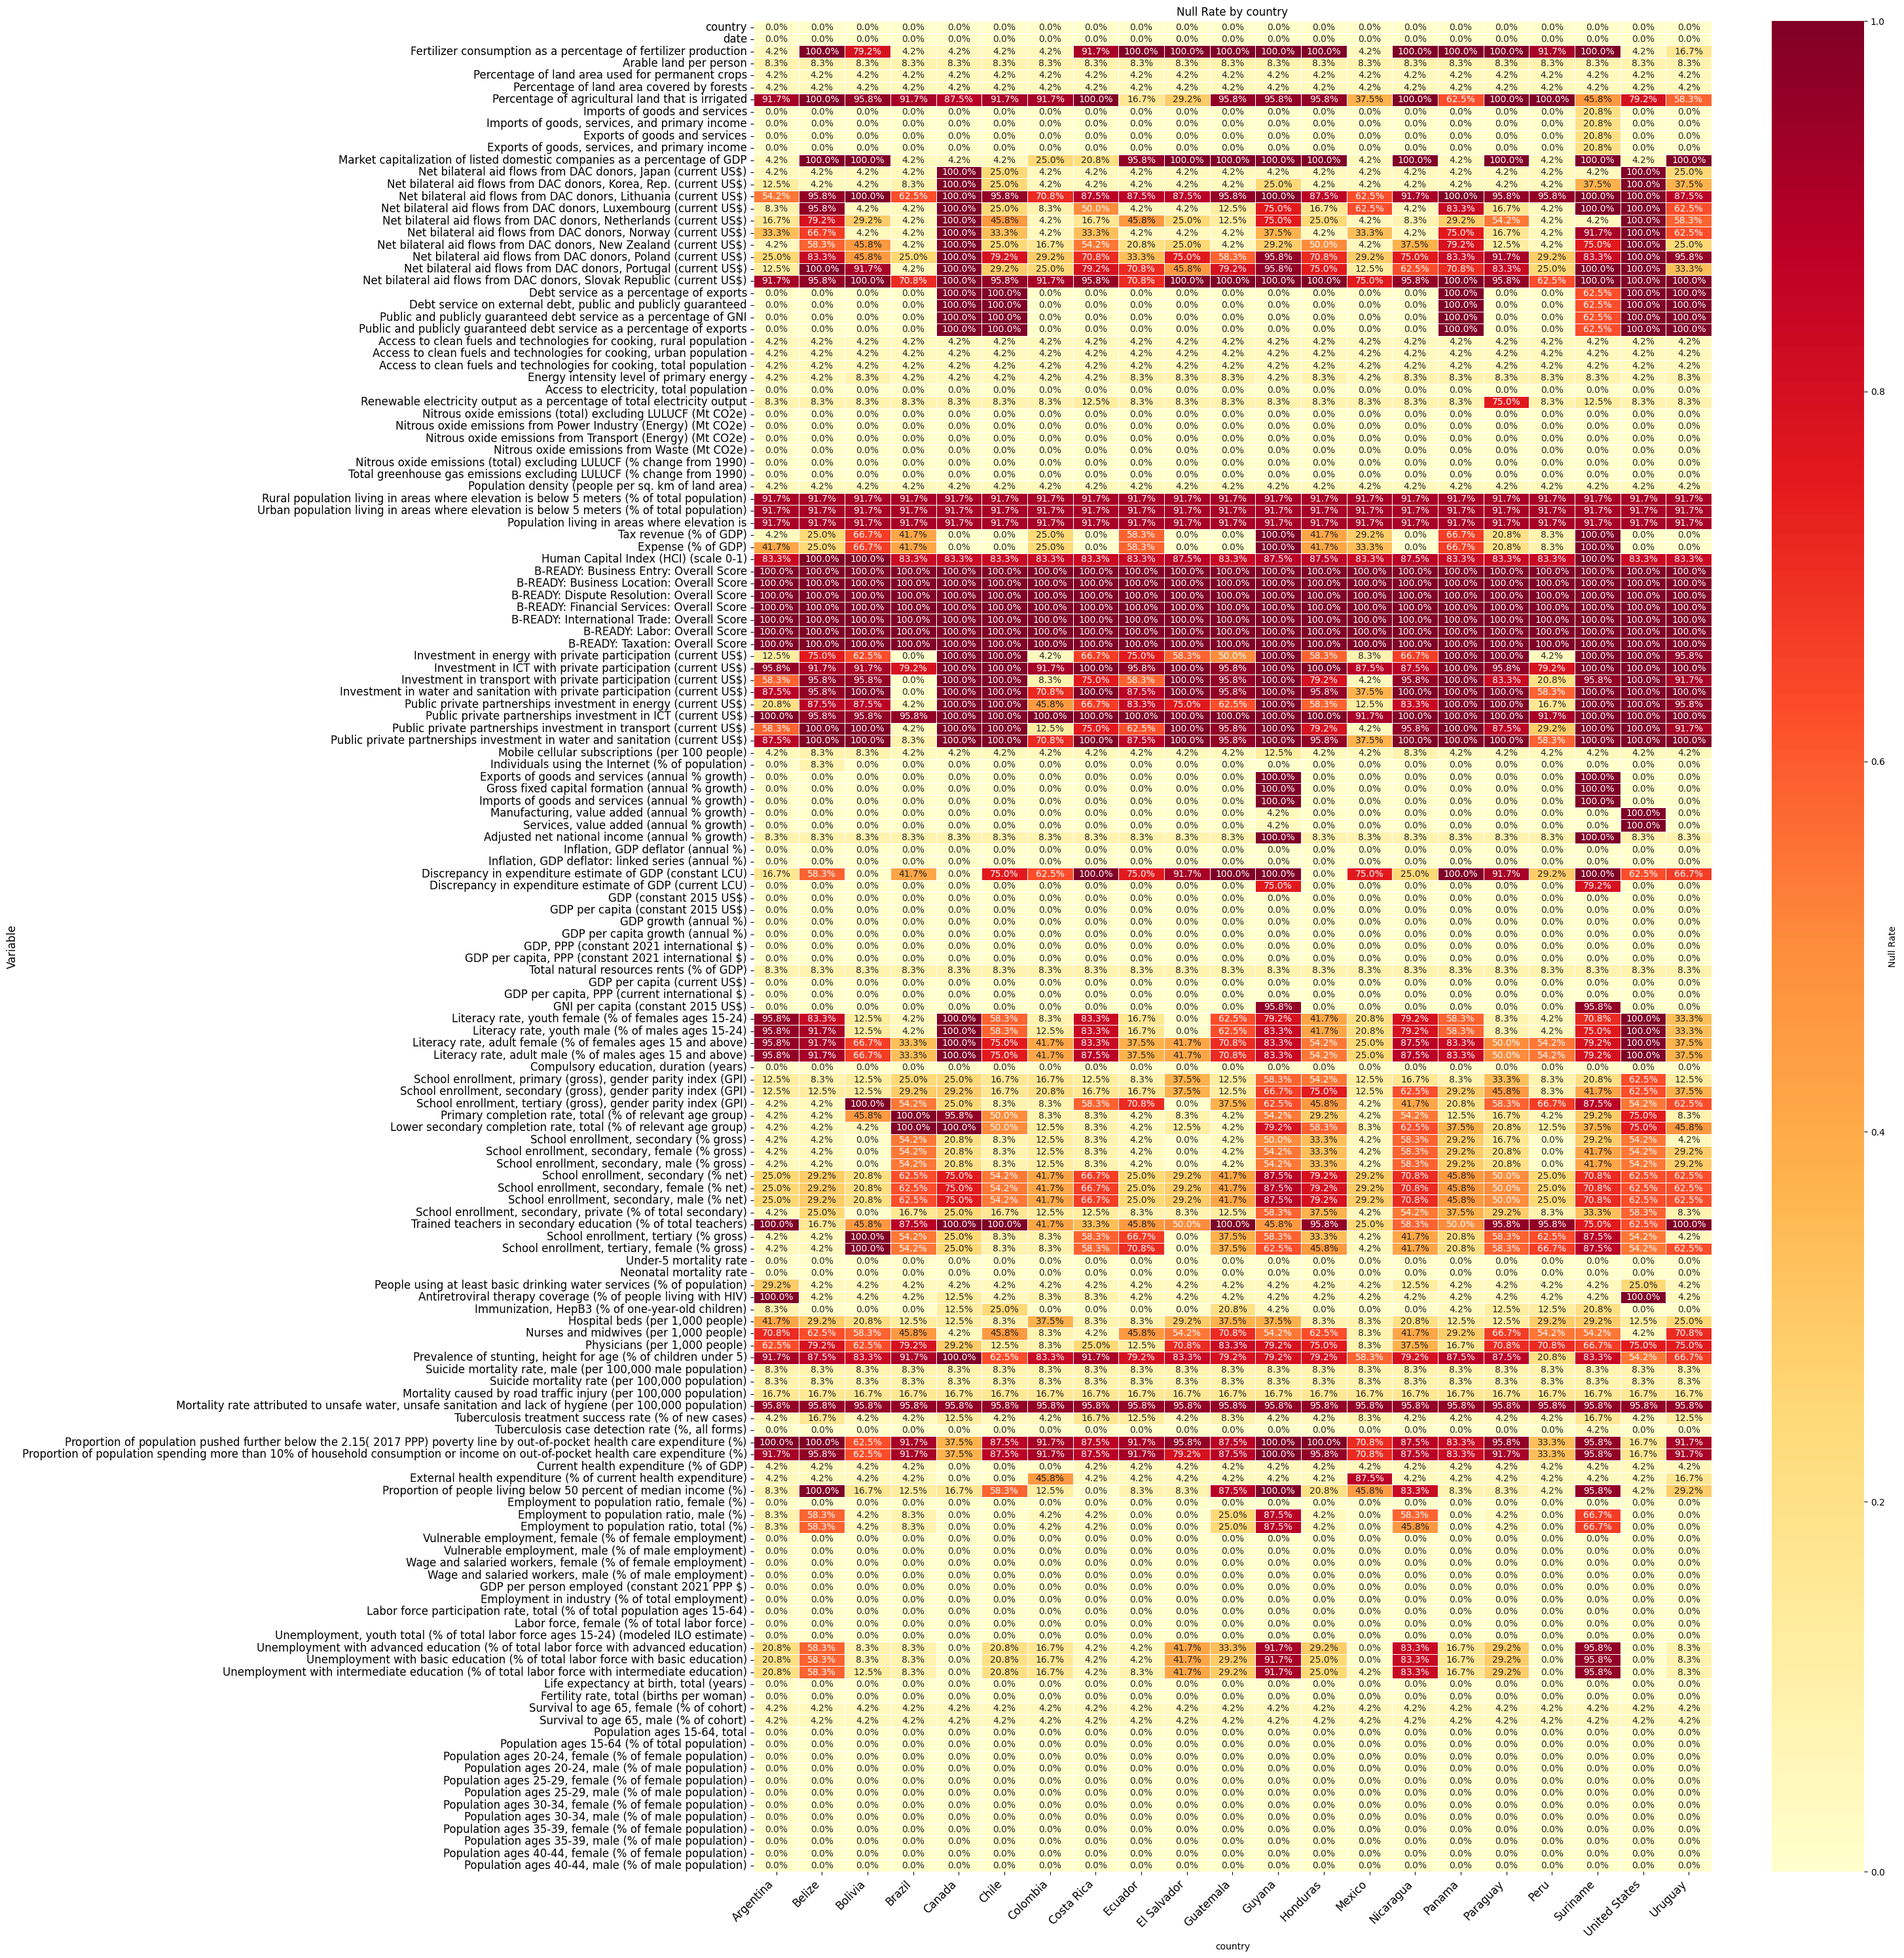

In [91]:
mull_heat_map(df,'country')

It is possible to see that the some indicators are not good, since most of its values are null

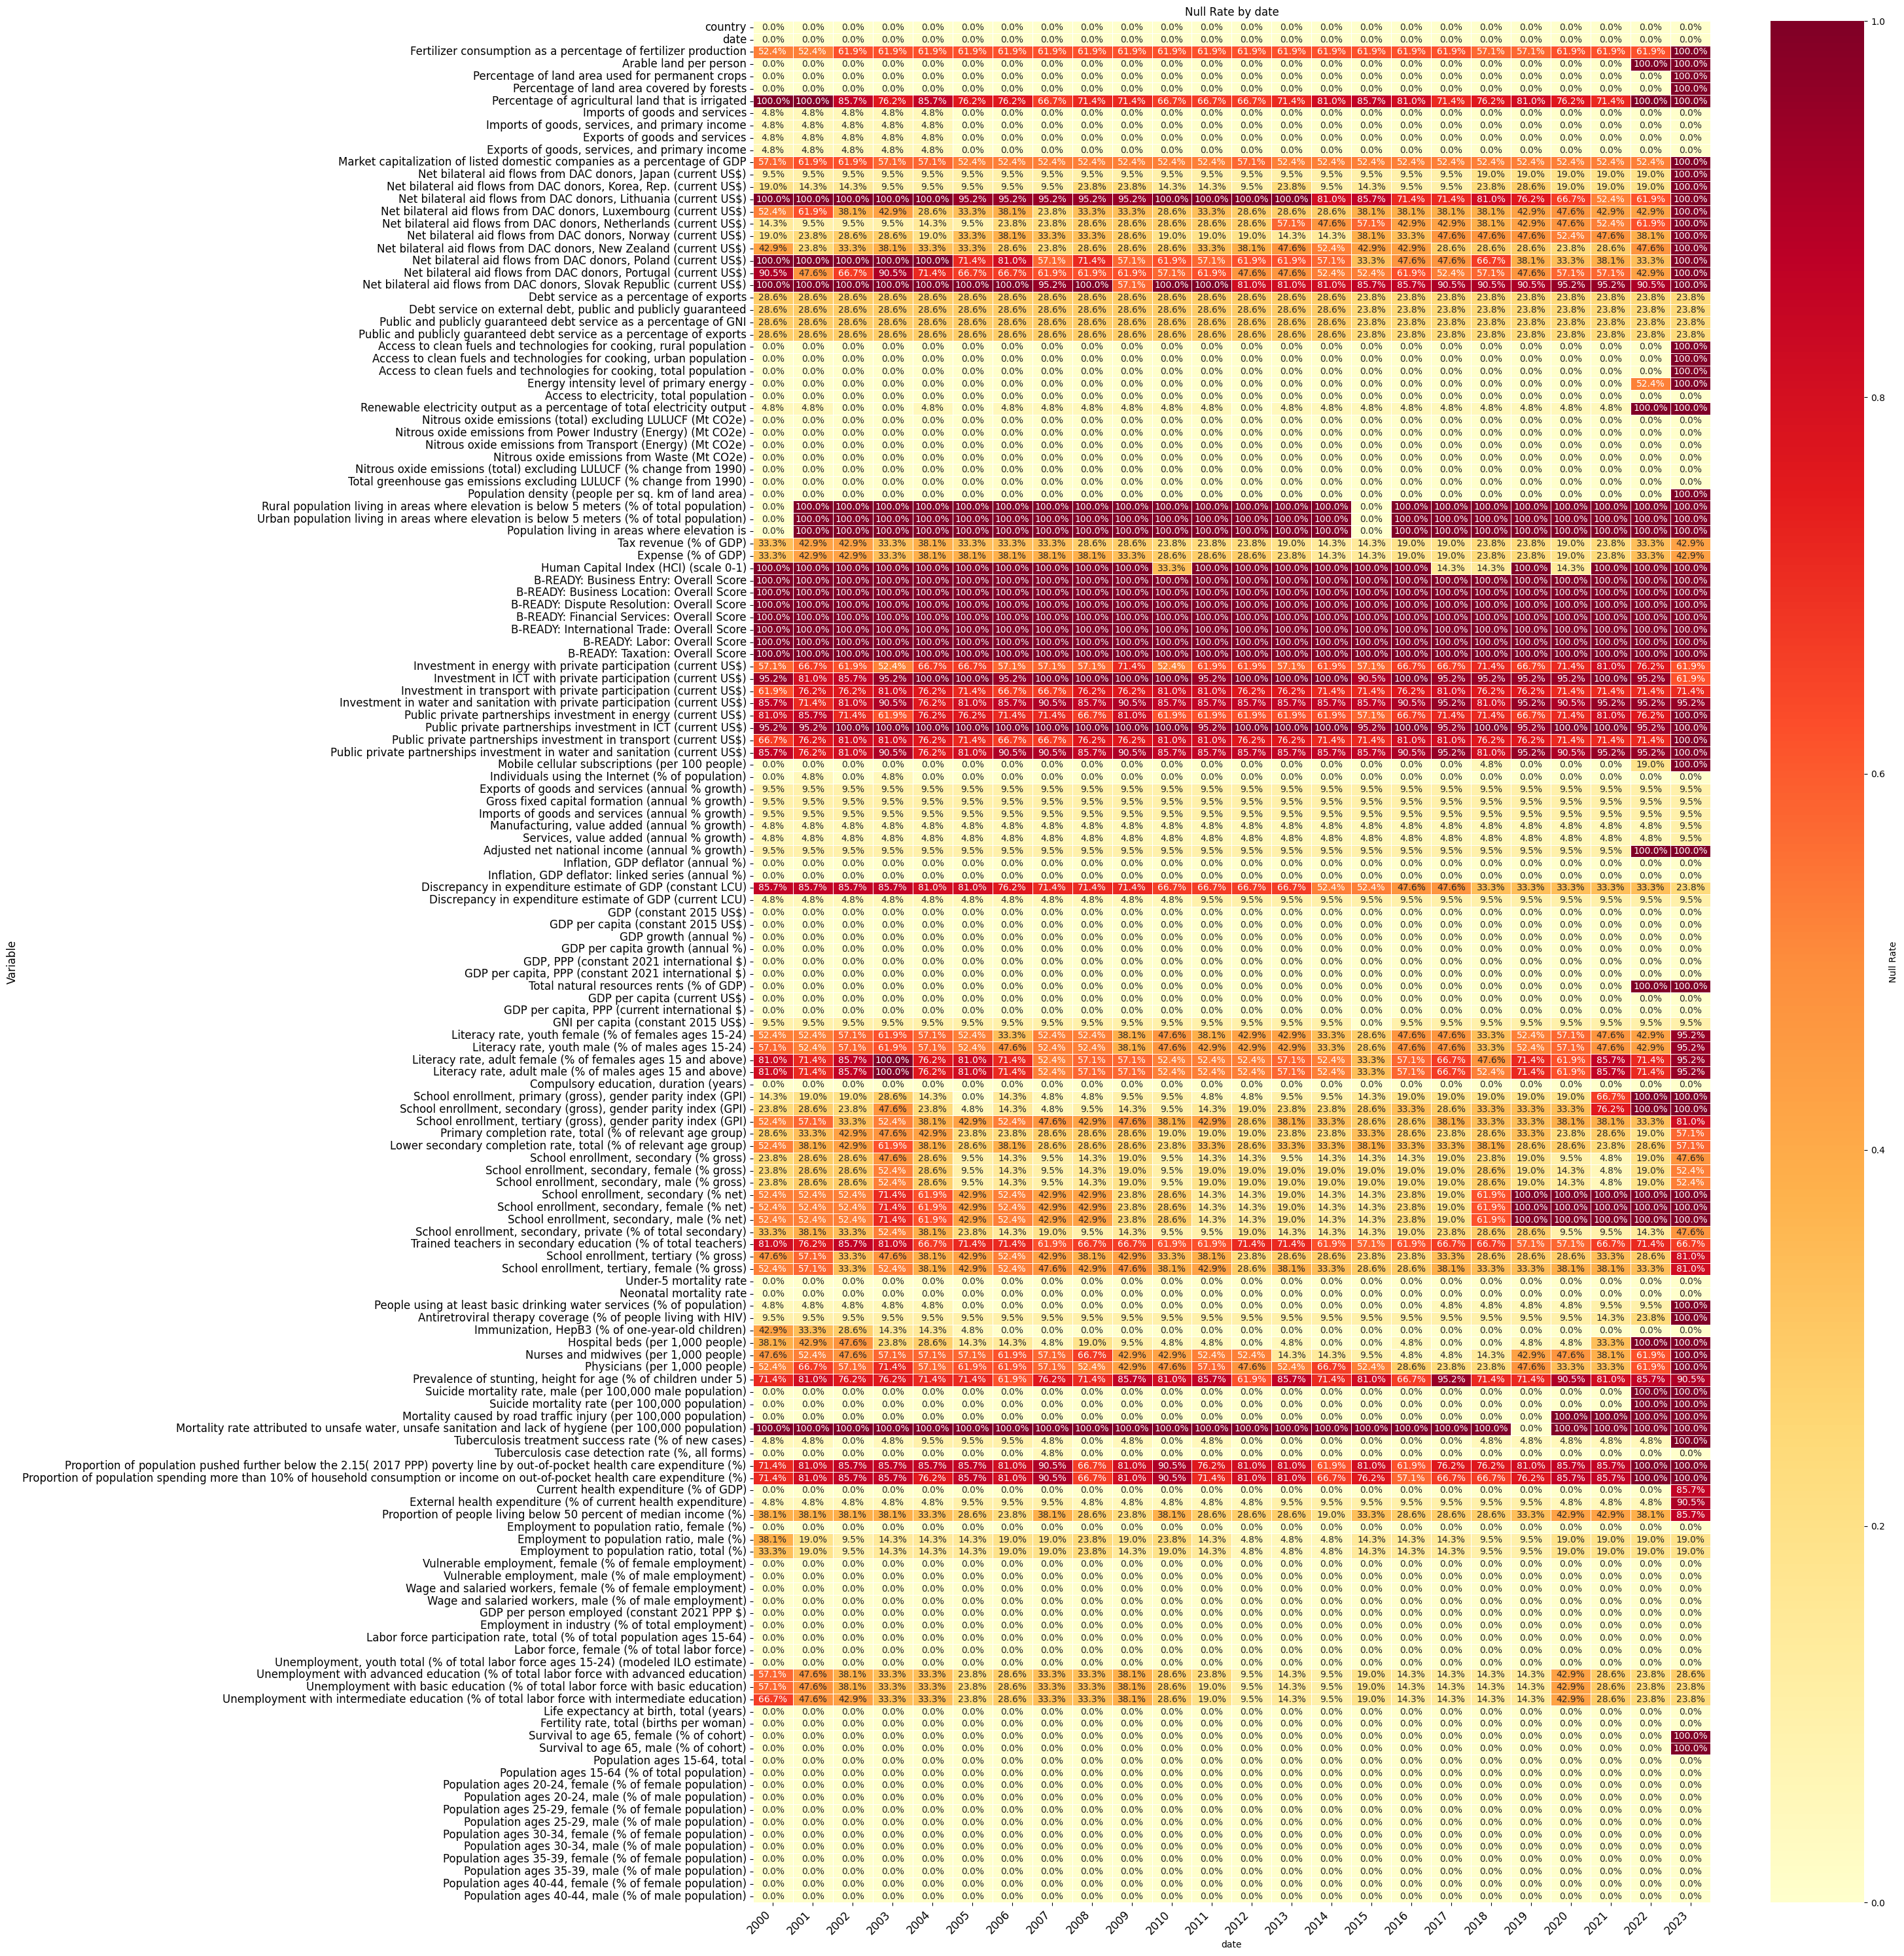

In [92]:
mull_heat_map(df,'date')

For this heat maps, we can see that the Mortality rate atributed to unsafe water and b-ready related indicators are not good indicators for us, as many others with higher percentage of missing values, since in many years we dont have any values in it, so we need to change that.

In [93]:
threshold = 0.4  # % of missingness

null_rates_country = df.groupby(['country']).apply(lambda x: x.isnull().mean()).drop(columns = ['country'] ).reset_index()

columns_not_to_keep = []

for country in null_rates_country['country'].unique():
    country_data = null_rates_country[null_rates_country['country'] == country]
    
    for column in null_rates_country.columns[2:]:  # Skip 'country' and 'date'
        null_rate = country_data[column].values[0]  # Get the actual value (assumed to be a float)
        
        if null_rate > threshold:
            if column not in columns_not_to_keep:
                columns_not_to_keep.append(column)


In [94]:
columns_to_keep = [col for col in df.columns if col not in columns_not_to_keep]

print(f'Columns that have been dropped {columns_not_to_keep}')
print(f'Quantity of indicators dropped {len(columns_not_to_keep)} \nQuantity of keeped indicators {len(columns_to_keep)}')
df_filtered = df[columns_to_keep]

Columns that have been dropped ['Percentage of agricultural land that is irrigated', 'Net bilateral aid flows from DAC donors, Lithuania (current US$)', 'Net bilateral aid flows from DAC donors, Slovak Republic (current US$)', 'Rural population living in areas where elevation is below 5 meters (% of total population)', 'Urban population living in areas where elevation is below 5 meters (% of total population)', 'Population living in areas where elevation is', 'Expense (% of GDP)', 'Human Capital Index (HCI) (scale 0-1)', 'B-READY: Business Entry: Overall Score', 'B-READY: Business Location: Overall Score', 'B-READY: Dispute Resolution: Overall Score', 'B-READY: Financial Services: Overall Score', 'B-READY: International Trade: Overall Score', 'B-READY: Labor: Overall Score', 'B-READY: Taxation: Overall Score', 'Investment in ICT with private participation (current US$)', 'Investment in transport with private participation (current US$)', 'Investment in water and sanitation with private

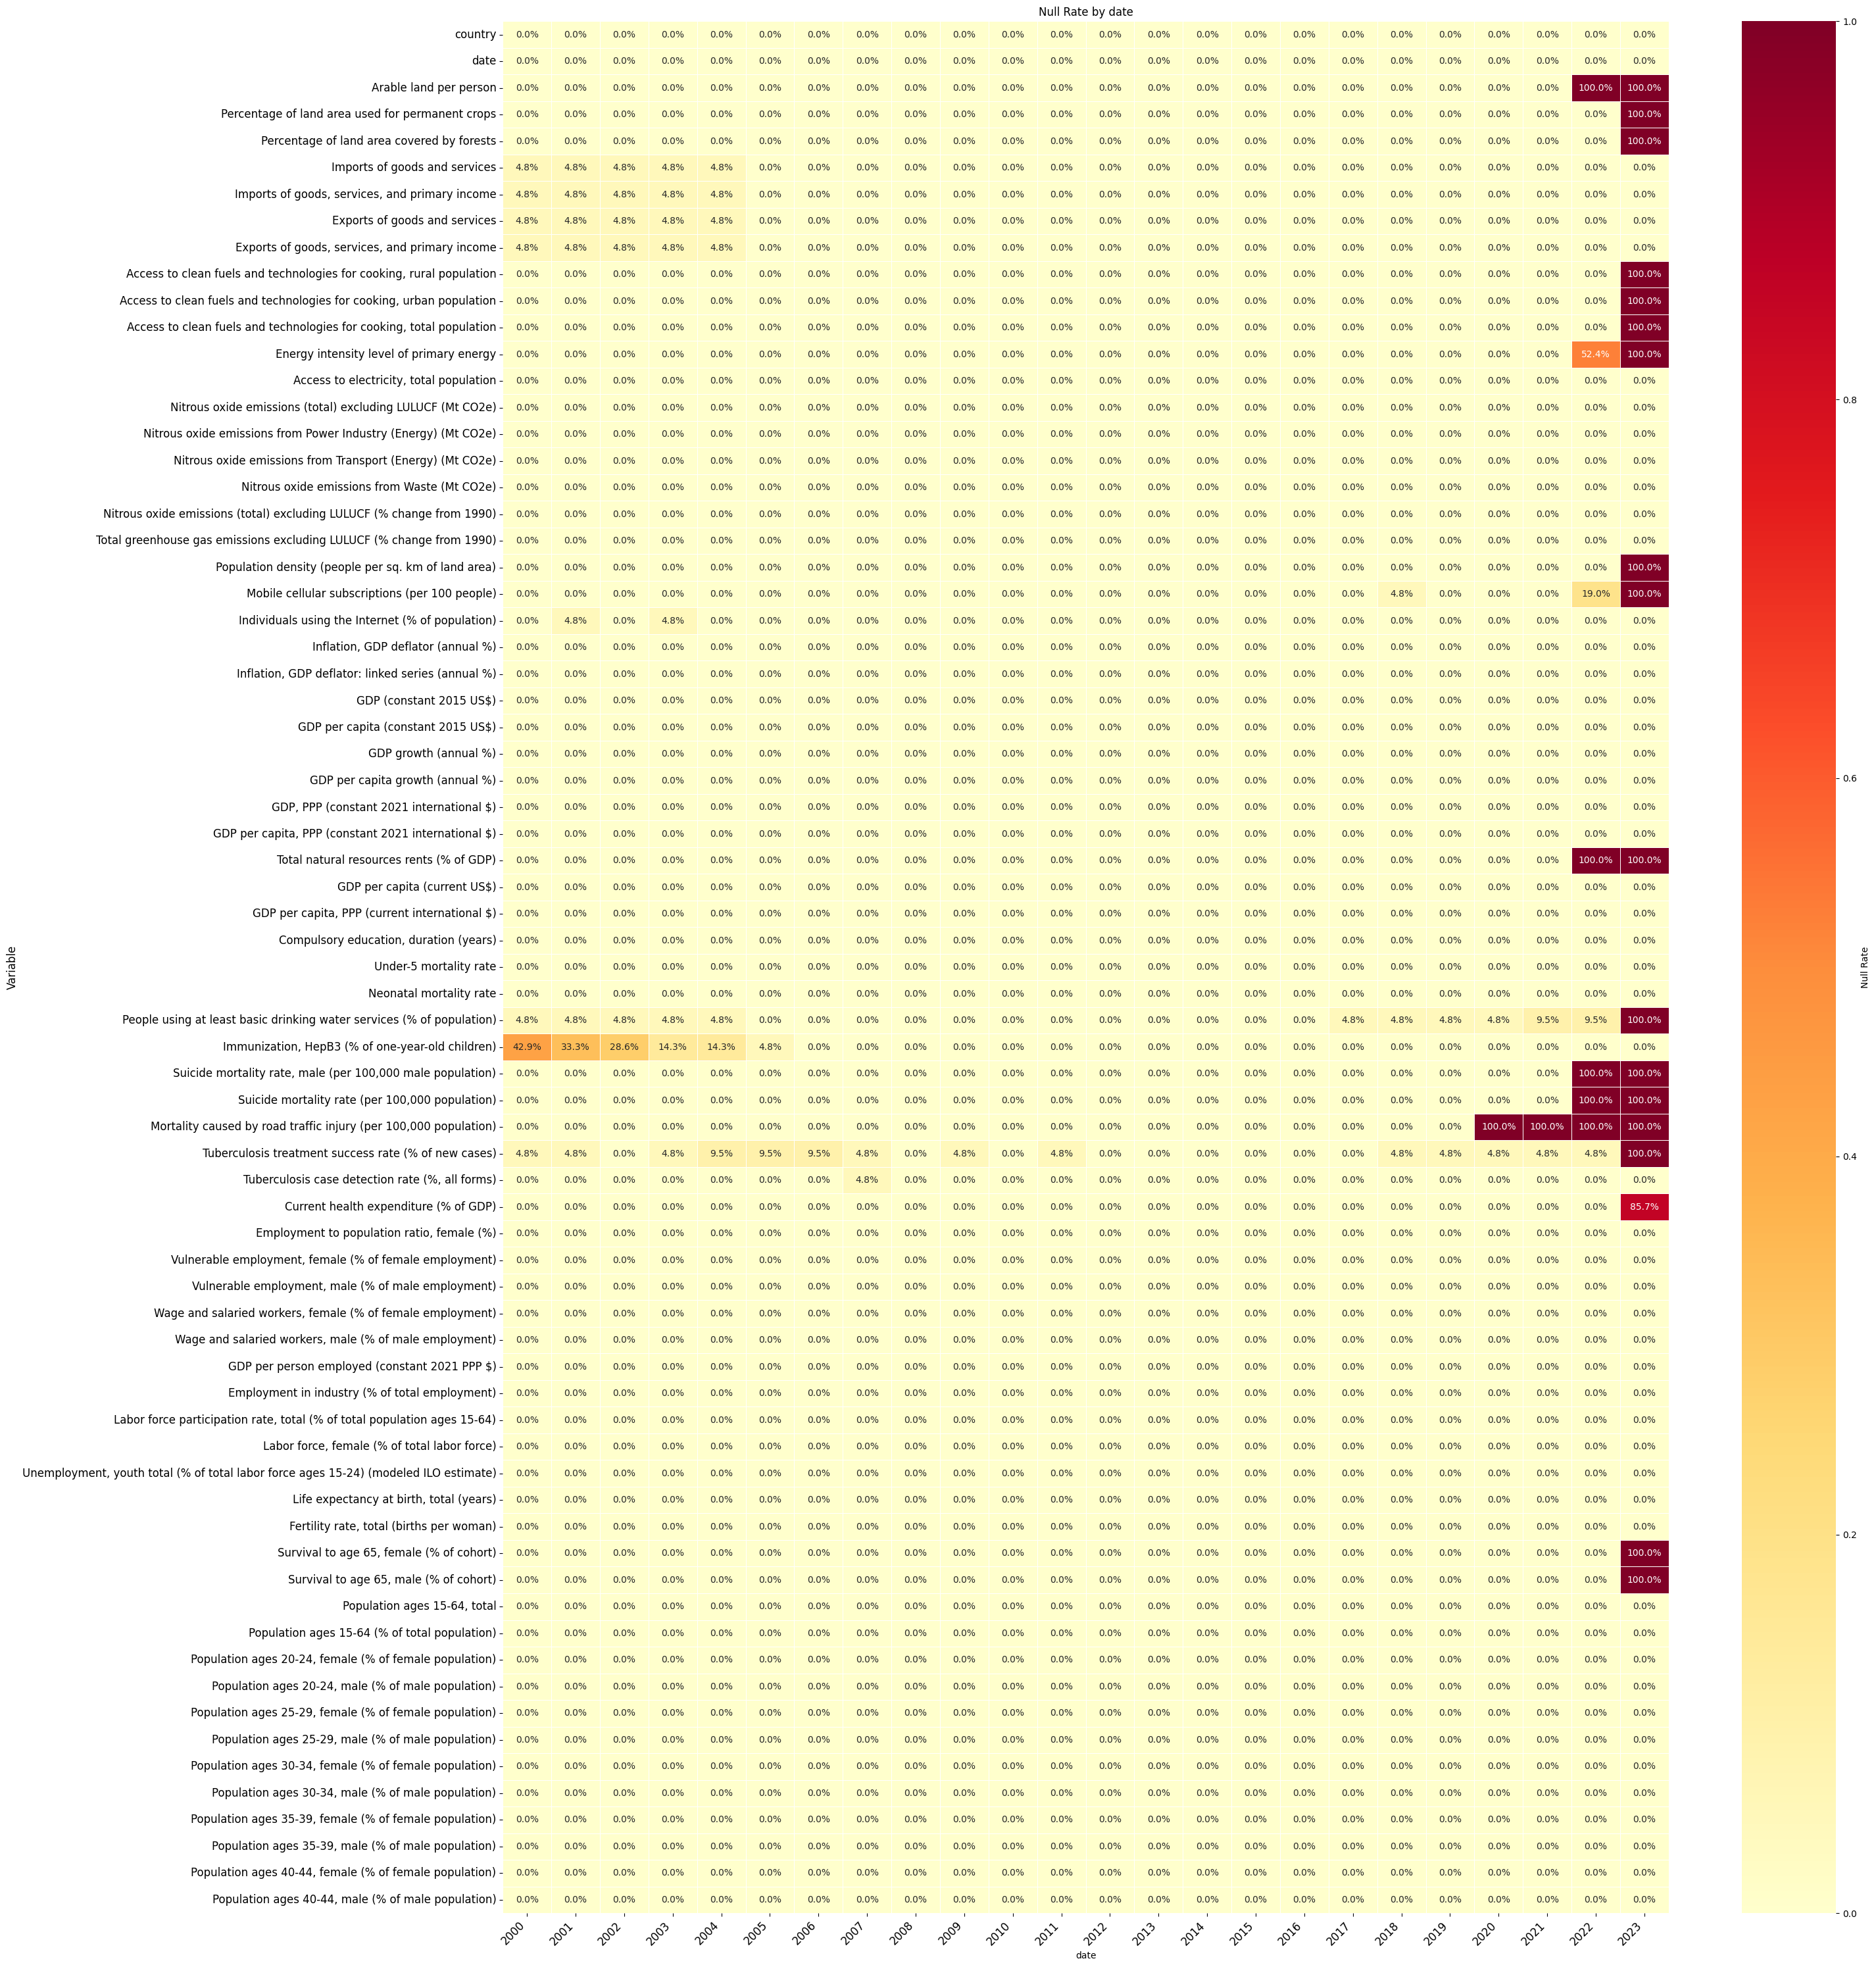

In [95]:
mull_heat_map(df_filtered,'date')

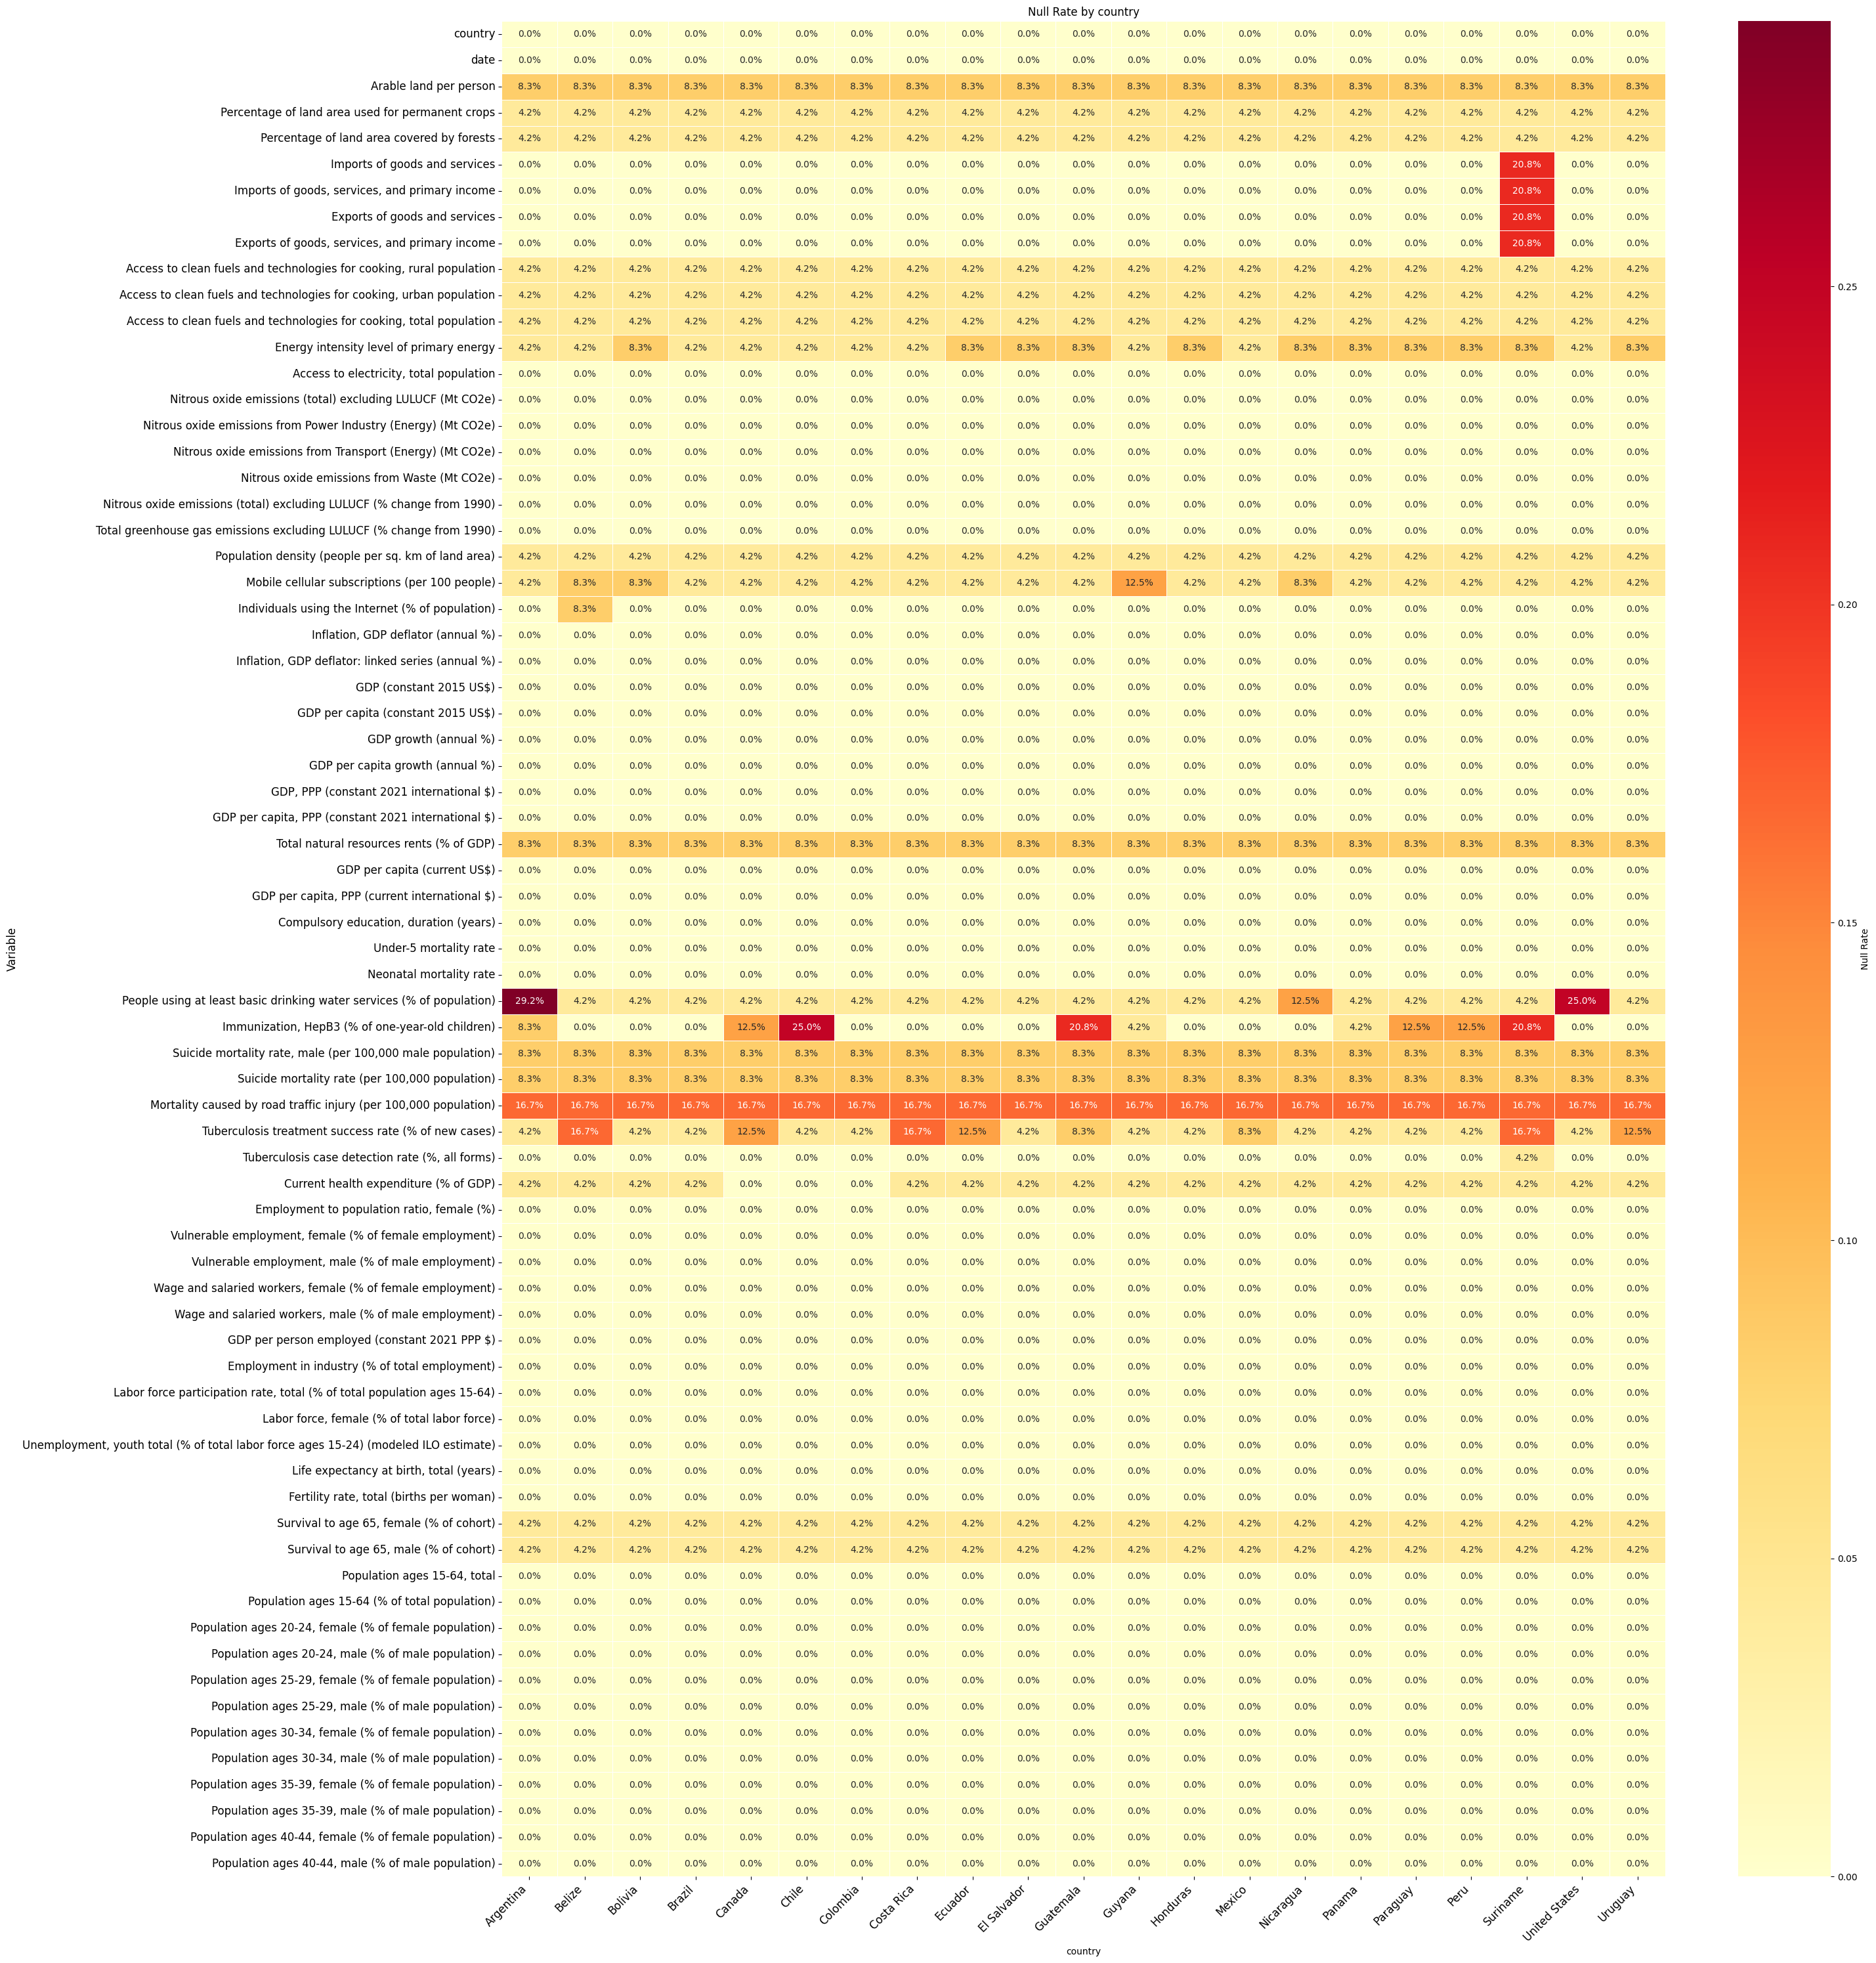

In [96]:
mull_heat_map(df_filtered,'country')

In [97]:
def imput_indicators_lr(df, country_col='country', year_col='date'):
    """
    Imputation using Lr
    
    Assumes:
    1. All indicator columns are numeric
    2. Year column is numeric
    3. Each country-indicator combo has ≥2 data points
    """
    df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
    # Get indicator columns (exclude metadata)
    indicators = [col for col in df.columns 
                 if col not in {country_col, year_col}]
    
    # Single-pass imputation
    def impute_group(group):
        for col in indicators:
            # Get known values
            known = group[group[col].notna()]
            X = known[[year_col]]
            y = known[col]
            
            # Train and predict (no length checks needed)
            model = LinearRegression().fit(X, y)
            missing = group[col].isna()
            if missing.any():
                group.loc[missing, col] = model.predict(group.loc[missing, [year_col]])
        return group
    
    return df.groupby(country_col, group_keys=False).apply(impute_group)
df_filtered_imputed = imput_indicators_lr(df_filtered)

In [98]:
def plot_indicator_by_country(df, indicator_name,x_axis='date'):
    """
    Plots the given indicator over time for each country in the DataFrame,
    with both a legend and the country name displayed at the end of each line.

    Parameters:
    - df: DataFrame containing 'country', 'date', and indicator columns
    - indicator_name: str, the name of the indicator to plot
    """
    plt.figure(figsize=(15, 10))

    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        if indicator_name in country_data.columns and not country_data[indicator_name].isna().all():
            plt.plot(country_data[x_axis], country_data[indicator_name], label=country)
            # Add country name at the end of the line
            last_valid_index = country_data[indicator_name].last_valid_index()
            if last_valid_index is not None:
                x = country_data.loc[last_valid_index, x_axis]
                y = country_data.loc[last_valid_index, indicator_name]
                plt.text(x, y, f' {country}', fontsize=8, ha='left', va='center')

    plt.title(f'{indicator_name} by {x_axis}')
    plt.xlabel(x_axis)
    plt.ylabel(indicator_name)
    plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Business questions

- 1 😷 Did the COVID-19 pandemic (2020–2022) affect the life expectancy at birth across the Americas?
- 2 🧑‍🌾 Which country had the highest GDP growth during this period?
- 3 🌎 How can we group countries in the Americas based on their post-pandemic socioeconomic and health recovery patterns (2020–2022) to identify investment priorities for international development organizations?

- Did the COVID-19 pandemic (2020–2022) affect the life expectancy at birth across the Americas?

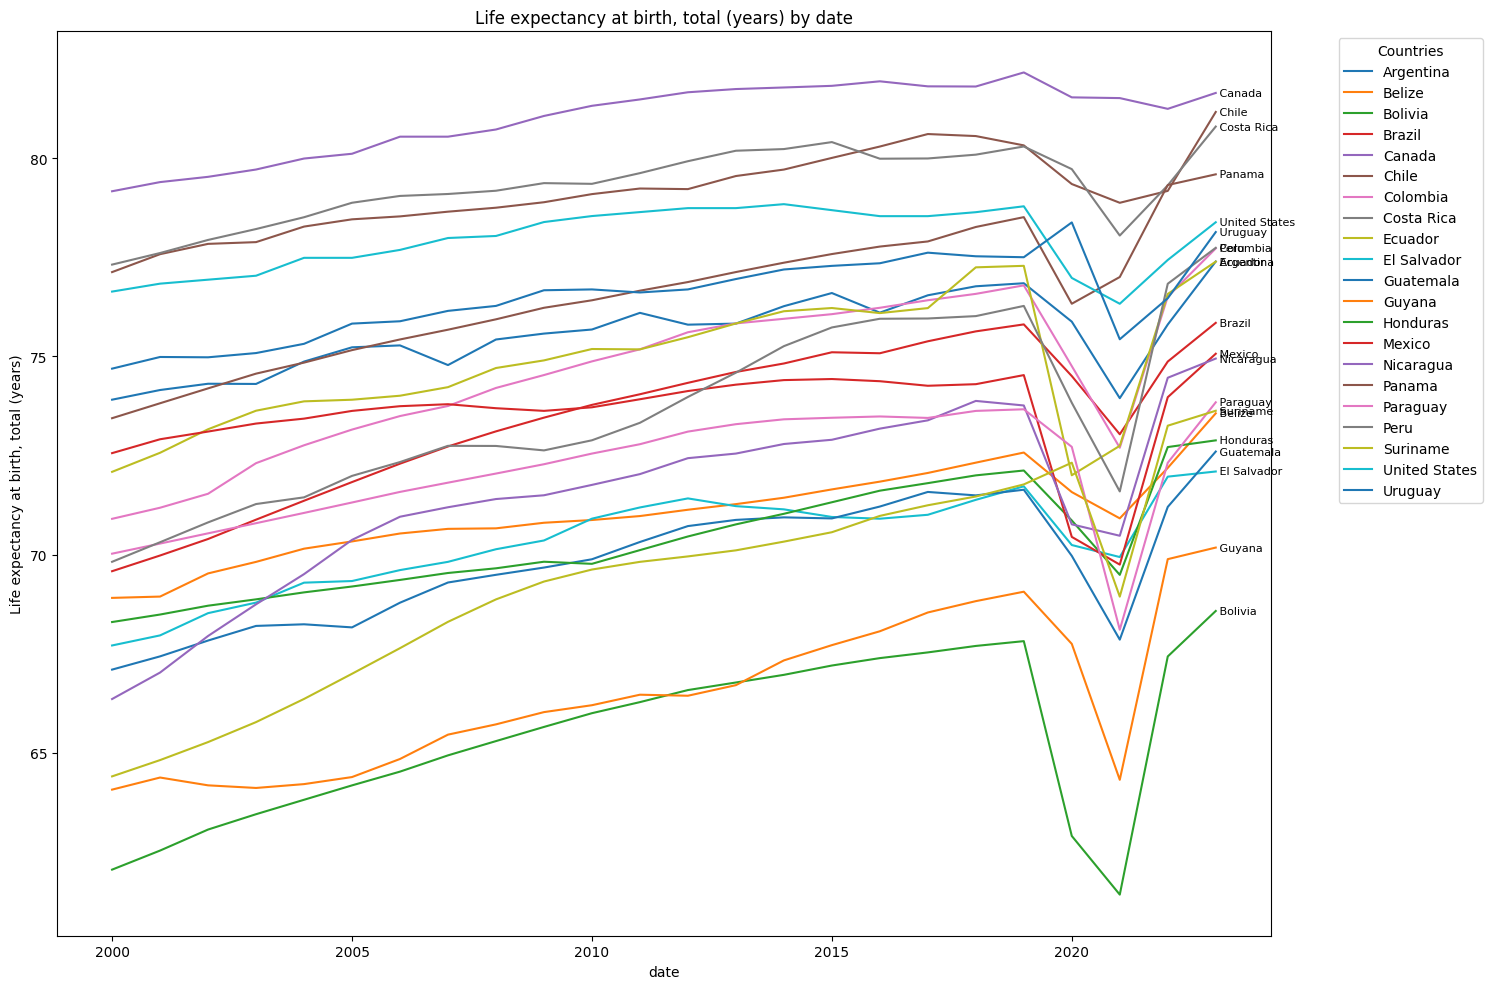

In [99]:
plot_indicator_by_country(df_filtered_imputed,'Life expectancy at birth, total (years)')

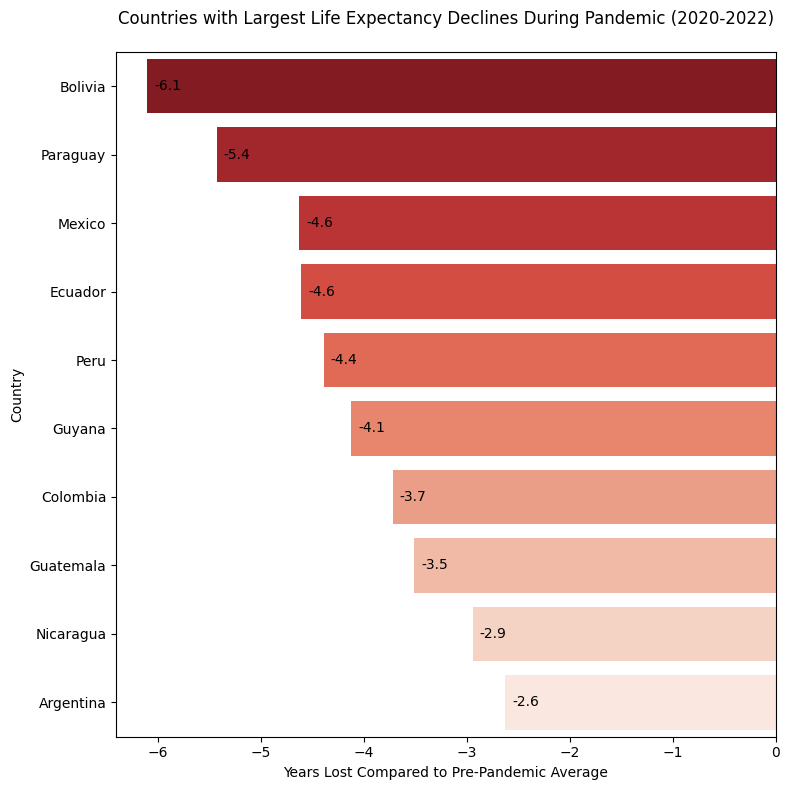

In [150]:
# Pivot for easier analysis
life_exp_pivot = df_filtered_imputed.pivot(index='country', columns='date', values='Life expectancy at birth, total (years)')

# Get pre-pandemic baseline (average of 2015-2019)
life_exp_pivot['pre_pandemic_avg'] = life_exp_pivot.loc[:, 2015:2019].mean(axis=1)

# Calculate change during pandemic years
for year in [2020, 2021, 2022]:
    life_exp_pivot[f'delta_{year}'] = life_exp_pivot[year] - life_exp_pivot['pre_pandemic_avg']

# Get worst year's decline
life_exp_pivot['max_decline'] = life_exp_pivot[[f'delta_{y}' for y in [2020,2021,2022]]].min(axis=1)

plt.figure(figsize=(8, 8))

# Top 10 most affected countries
top_declines = life_exp_pivot.nsmallest(10, 'max_decline').sort_values('max_decline')

# Bar plot
ax = sns.barplot(data=top_declines, 
                 y=top_declines.index, 
                 x='max_decline',
                 palette='Reds_r')

plt.title('Countries with Largest Life Expectancy Declines During Pandemic (2020-2022)', pad=20)
plt.xlabel('Years Lost Compared to Pre-Pandemic Average')
plt.ylabel('Country')


#Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_width():.1f}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()

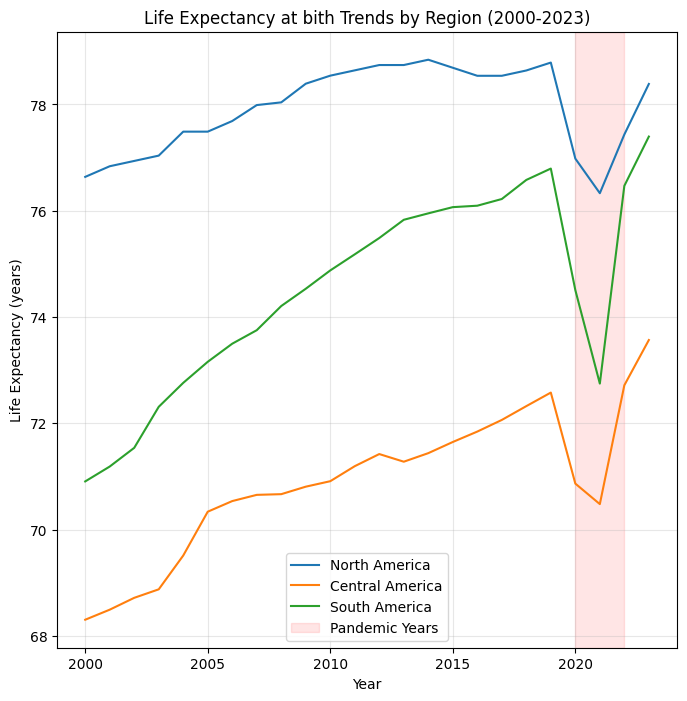

In [101]:
# Calculate regional averages
americas_regions = {
    'North America': ['United States', 'Canada', 'Mexico'],
    'Central America': ['Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay']
}

plt.figure(figsize=(8, 8))

for region, countries in americas_regions.items():
    region_df = df_filtered_imputed[df_filtered_imputed['country'].isin(countries)]
    sns.lineplot(data=region_df, x='date', y='Life expectancy at birth, total (years)', 
                 label=region, ci=None, estimator='median')

plt.title('Life Expectancy at bith Trends by Region (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Life Expectancy (years)')
plt.axvspan(2020, 2022, color='red', alpha=0.1, label='Pandemic Years')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Answer to the first question:** Yes, the COVID-19 pandemic affected life expectancy, particularly in South American countries like Bolivia, Paraguay, and Ecuador. The chart Life Expectancy at Birth Trends by Region (2000–2023) shows that countries from South America had less reliable healthcare systems or were more affected by the pandemic compared to countries from North and Central America. Despite this, it is clear that Central American countries generally have lower life expectancy overall.

- Which country had the highest GDP growth during this period?

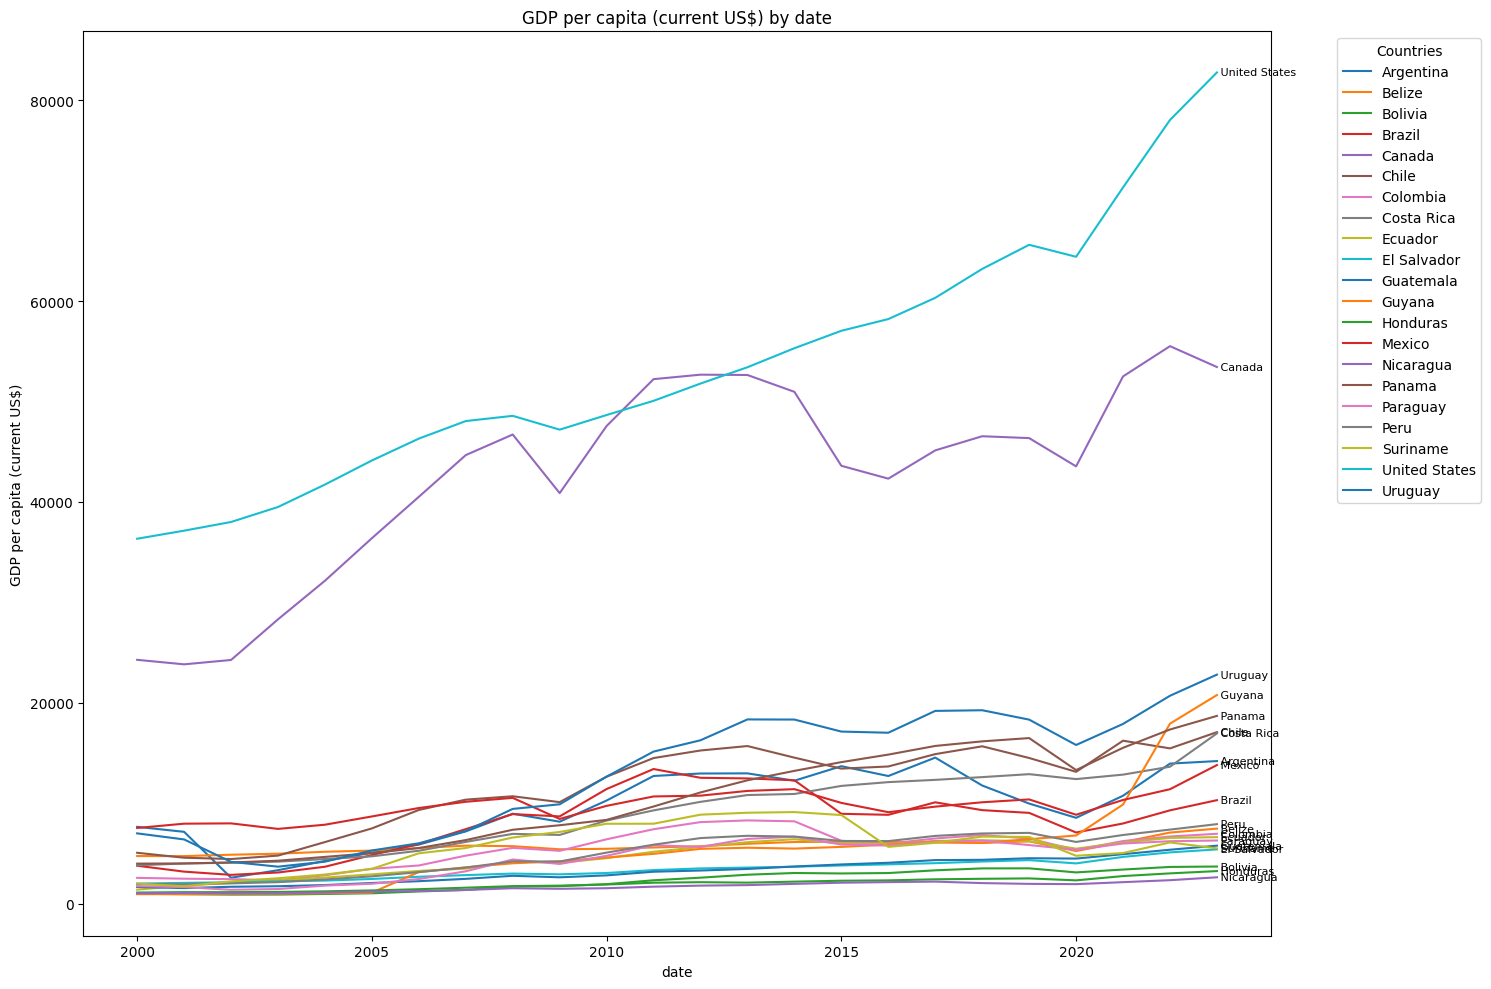

In [151]:
plot_indicator_by_country(df_filtered_imputed,'GDP per capita (current US$)')

In [ ]:
# Keep only the needed columns
growth_df = df_filtered_imputed[['country', 'date','GDP per capita (current US$)']]
max_year = growth_df.date.max()
min_year = growth_df.date.min()
growth_df.sort_values(by= 'country',inplace=True)
max = growth_df[growth_df['date'] == max_year]['GDP per capita (current US$)'].values
min = growth_df[growth_df['date'] == min_year]['GDP per capita (current US$)'].values

diff = max - min

df_diff = pd.DataFrame.from_dict({'country':growth_df.country.unique(),'gdp_max':max,'gdp_min':min,'gdp_diff':diff})
df_diff['gdp_diff_pct'] = (df_diff['gdp_max']-df_diff['gdp_min'])/df_diff['gdp_min']
df_diff.sort_values(by='gdp_diff_pct',ascending=False,inplace = True)

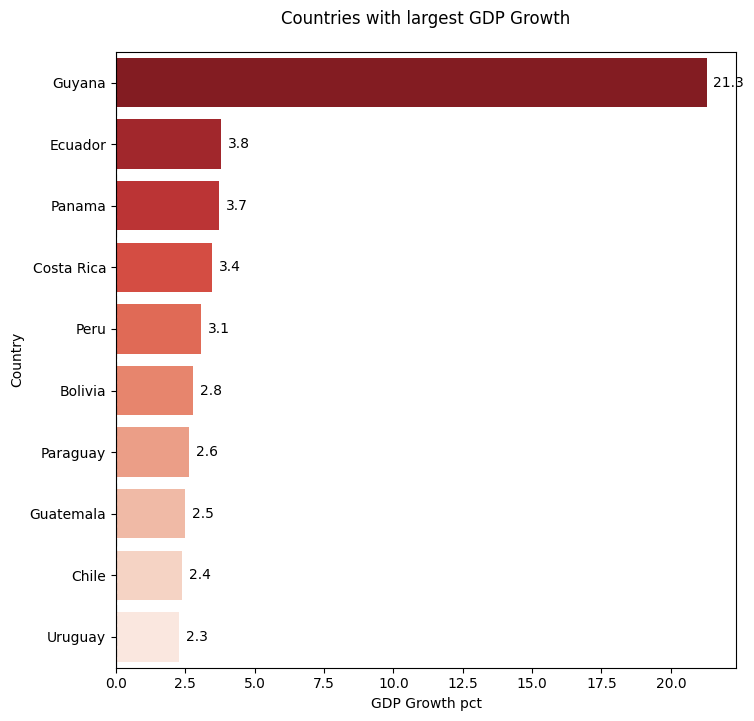

In [ ]:
plt.figure(figsize=(8, 8))

# Bar plot
max_gdp_growth_pdct = df_diff.nlargest(10, 'gdp_diff_pct').sort_values('gdp_diff_pct',ascending=False)

ax = sns.barplot(data=max_gdp_growth_pdct, 
                 y='country', 
                 x='gdp_diff_pct',
                 palette='Reds_r')

plt.title('Countries with largest GDP Growth', pad=20)
plt.xlabel('GDP Growth pct')
plt.ylabel('Country')
plt.axvline(0, color='black', linestyle='--')

#Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_width():.1f}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.show()


**Answer to the second question:** The United States and Canada clearly stand out with the highest GDP per capita among all countries in the Americas, as shown in the first graph. Their economic development is significantly ahead of the rest, with the U.S. surpassing $80,000 and Canada above $50,000 in recent years. This reflects their well-established economies and high standards of living.

In contrast, the first graph highlights the countries with the highest  GDP growth rates between 2000 and 2023. Guyana leads by a wide margin, with over 21% annual GDP growth—a remarkable figure. This rapid expansion is largely attributed to recent offshore oil discoveries, which have transformed its economic prospects. Other countries like Ecuador, Panama, and Costa Rica also show solid growth, though much more modest in comparison.

- How can we group countries in the Americas based on their post-pandemic socioeconomic and health recovery patterns (2020–2022) to identify investment priorities for international development organizations?

In [227]:
df = df_filtered_imputed.copy()

# 1. Filter to the most recent year
target_year = df['date'].max()
df_latest = df[df['date'] == target_year].copy()

# 2. Select all numeric features (excluding 'country' and 'date') for PCA
features = [col for col in df_latest.columns if col not in ['country', 'date']]
X = df_latest[features].values

# 3. Apply StandardScaler to normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This centers and scales the data

# 4. Perform PCA on the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)  

# Explained variance
print("Explained variance per component:")
print(pca.explained_variance_ratio_)

Explained variance per component:
[3.31547123e-01 1.56478329e-01 1.04805833e-01 7.61361596e-02
 5.86637018e-02 4.86329542e-02 4.35027309e-02 3.34502880e-02
 3.12779463e-02 2.51179803e-02 1.95754769e-02 1.59388891e-02
 1.22973945e-02 1.04034663e-02 8.91341510e-03 6.83389590e-03
 5.67879002e-03 4.84962347e-03 3.77694966e-03 2.11905393e-03
 1.88554853e-33]


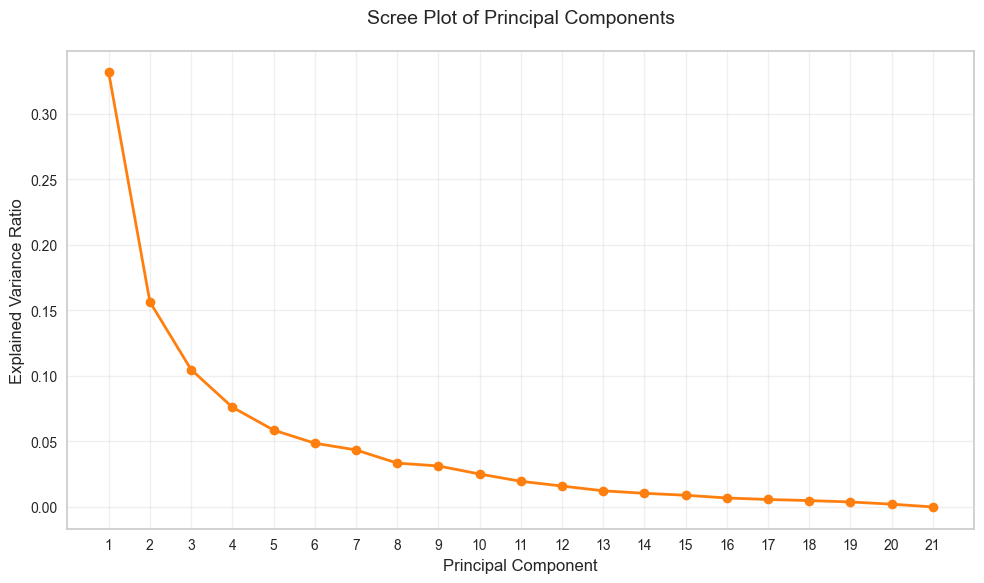

In [228]:
# Visualize the scree plot
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 
         'o-', 
         linewidth=2, 
         color=colors(1))  # Use first color from tab10 palette
plt.title('Scree Plot of Principal Components', fontsize=14, pad=20)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.3)
plt.tight_layout() 
plt.show()

In [229]:

# 4. Determine number of components to explain 90% variance
explained = pca.explained_variance_ratio_.cumsum()
n_selected = (explained >= 0.9).argmax()+1
print(f"Selecting top {n_selected} PCA components explaining {explained[n_selected-1]:.2%} variance.")
X_selected = X_pca[:, :n_selected]


Selecting top 10 PCA components explaining 90.96% variance.


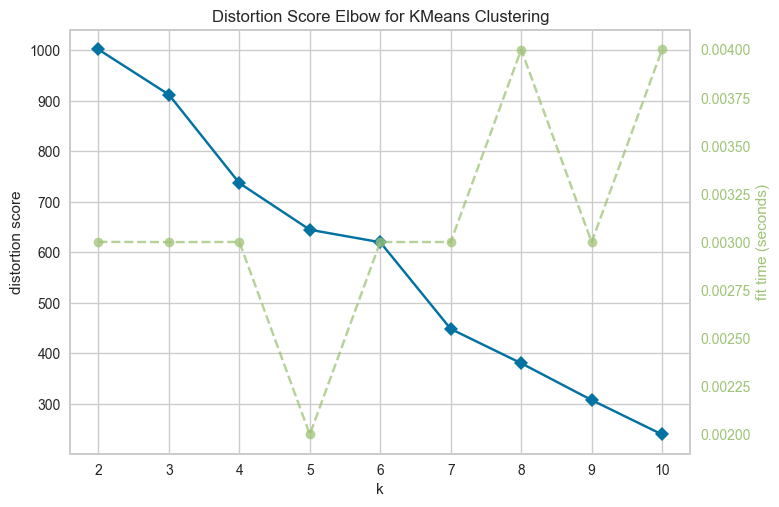

Best value using inertia None


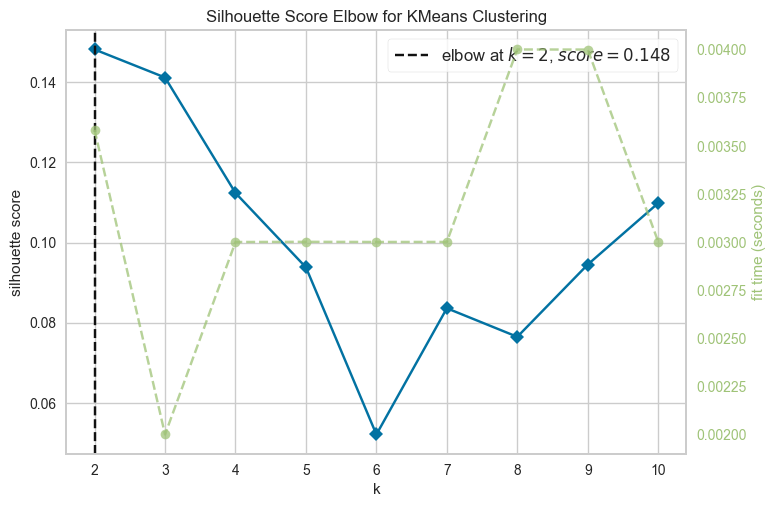

Best value using Silhouette 2


In [230]:
from yellowbrick.cluster import KElbowVisualizer

# Inertia (Elbow) Measures compactness (how close points are within clusters). Always decreases as K increases.
visualizer_inertia = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='distortion')
visualizer_inertia.fit(X_selected)
visualizer_inertia.show()
print(f'Best value using inertia {visualizer_inertia.elbow_value_}')

# Silhouette - Silhouette measures quality of separation
visualizer_silhouette = KElbowVisualizer(KMeans(random_state=42), k=(2,11), metric='silhouette')
visualizer_silhouette.fit(X_selected)
visualizer_silhouette.show()
print(f'Best value using Silhouette {visualizer_silhouette.elbow_value_}')



I selected the Silhouette Score over the Elbow Method as the primary criterion for determining the optimal number of clusters. While the Elbow Method is useful for identifying the point where additional clusters result in smaller improvements in within-cluster variance (inertia), it does not directly account for how well-separated the clusters are. The Silhouette Score, by contrast, evaluates both cohesion within clusters and separation between clusters, providing a more robust indication of cluster validity. Although the Elbow Method suggested the use of 7 clusters, the Silhouette Score revealed that a 2-cluster solution offered better-defined and more interpretable groupings. Given the goal of maximizing interpretability and ensuring meaningful differentiation between clusters, the final decision was guided by the Silhouette Score.

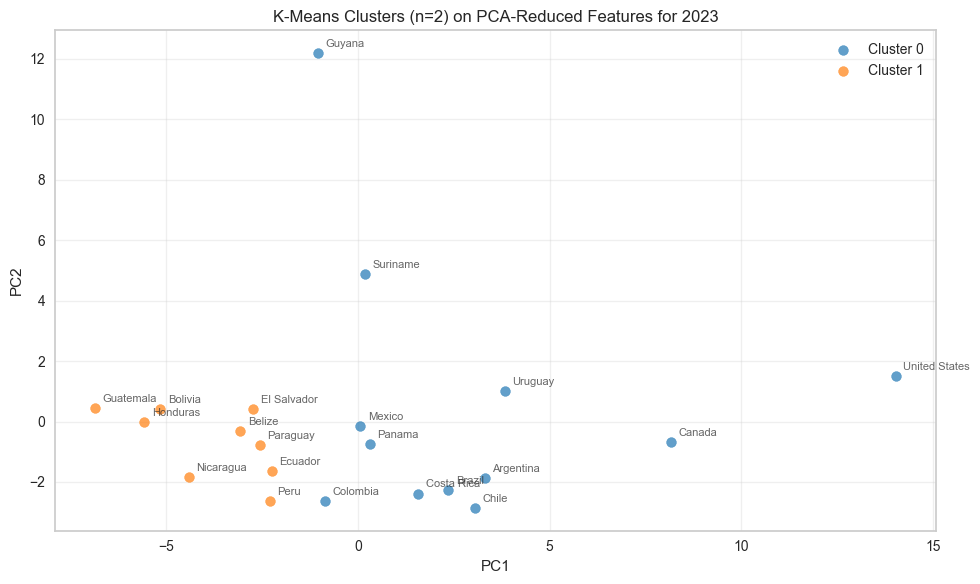

In [231]:

# 5. Apply K-Means clustering on the selected principal components
n_clusters = visualizer_silhouette.elbow_value_ # adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected)
df_latest['cluster'] = cluster_labels

# 6. Visualize clusters in the space of the first two principal components
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10')
for label in range(n_clusters):
    mask = cluster_labels == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=50,
        alpha=0.7,
        color=colors(label),
        label=f'Cluster {label}'
    )
offset = 0.2
for i in range(X_pca.shape[0]):
    plt.text(
        X_pca[i, 0]+offset, X_pca[i, 1]+offset, 
        df_latest['country'].iloc[i],  
        fontsize=8,
        alpha=0.7
    )


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means Clusters (n={n_clusters}) on PCA-Reduced Features for {target_year}')
plt.legend(loc='best')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()


**Answer to the third question:** The United States is far from all other countries, even within Cluster 0, followed by Canada. This indicates that these countries have very distinct features compared to the others. This fact suggests that the United States and Canada has stronger indicators relative to other countries as expected.

Cluster 0 appears to represent higher-performing or more developed nations, while Cluster 1 groups less developed or similarly smaller economies closer together.

Since we used a small number of clusters, it is expected that our clustering results in good separation between clusters and interpretability.